# Physics-Informed Kolmogorov-Arnold Network (PI-KANs) in Neuromancer

This tutorial demonstrates the use of [PINNs](https://en.wikipedia.org/wiki/Physics-informed_neural_networks) for solving partial differential equations (PDEs) in the Neuromancer library using Kolmogorov-Arnold networks (KANs).

<img src="https://github.com/pnnl/neuromancer/blob/master/examples/figs/PINNs.png?raw=1" width="600">  

### References

[1] [Liu, Ziming, et al. (2024). KAN: Kolmogorov-Arnold Networks.](https://arxiv.org/abs/2404.19756)

[2] https://github.com/Blealtan/efficient-kan

[3] [Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations.](https://www.sciencedirect.com/science/article/abs/pii/S0021999118307125)

[4] https://github.com/jdtoscano94/Learning-Python-Physics-Informed-Machine-Learning-PINNs-DeepONets/tree/main

[5] https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main


## Install (Colab only)
Skip this step when running locally.

In [1]:
# !pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"
# !pip install pyDOE

## Imports

In [2]:
# import sys
# sys.path.append('../../src')

import torch
import torch.nn as nn
import numpy as np
# data imports
from scipy.io import loadmat
# plotting imports
import matplotlib.pyplot as plt
# aux imports
from time import time

In [3]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)
#PyTorch random number generator
torch.manual_seed(1234)
# Random number generators in other libraries
np.random.seed(1234)
# Device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Problem Setup

**The [lid-driven cavity flow](https://www.cfd-online.com/Wiki/Lid-driven_cavity_problem)** is a classic benchmark problem in fluid dynamics, where the incompressible Navier-Stokes equations are solved in a squared domain, under Dirichlet boundary conditions. The problem, in its dimensionless form, is governed by the the momentum and continuity equations 

$$\frac{\partial \boldsymbol{v}^*}{\partial t}+ \boldsymbol{v}^* \cdot \nabla^* \boldsymbol{v}^* = - \nabla^* P^* \frac{1}{Re} \nabla^2 \boldsymbol{v}^*, $$
$$ \nabla^* \boldsymbol{v} = 0,$$

where $Re$ denotes the Reynolds number, a dimensionless number that quantifies that ratio between inertial (advective) and viscous (diffusive) effects, and $P$ is the pressure field.

Assuming a two-dimensional space, the fluid velocity $\boldsymbol{v}^*$ and position $\boldsymbol{x}^*$ fields are vectors with components $\boldsymbol{v}^* = [v_x^*, v_y^*]^T$ and $\boldsymbol{x}^* = [x^*, y^*]^T$, with

$$x, y \in[0,1],$$
$$t\in \mathcal{R},$$


**Initial Condition:**
$$v_x^*(x, y, t=0) = v_y^*(x, y, t=0) = 0$$
$$P(x, y, t=0) = 1$$


**Boundary Conditions:**

$$v_x^*(x, y=1, t) = 1$$
$$v_x^*(x=0, y, t) = v_y^*(x=0, y, t) = 0$$
$$v_x^*(x=1, y, t) = v_y^*(x=1, y, t) = 0$$
$$v_x^*(x, y=0, t) = v_y^*(x, y=0, t) = 0$$
$$v_y^*(x, y=1, t) = 0$$



## Sample collocation points

In [4]:
def boundary_layer_sampling_square(Nx,Ny):
    x = torch.linspace(0, 1, Nx)
    y = torch.linspace(0, 1, Ny)
    return x, y


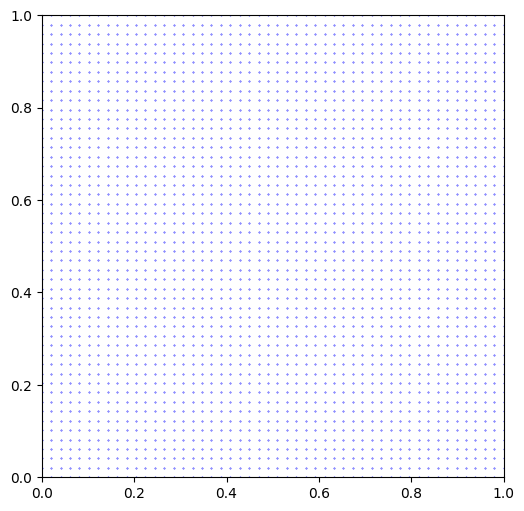

In [5]:
# Define number of collocation points in x and y
Nx = 50
Ny = 50

x, y = boundary_layer_sampling_square(Nx, Ny)
X,Y = torch.meshgrid(x,y, indexing="ij")

# Define Reynolds number
Re = 100.


# # Plot the original and transformed grids
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Transformed grid
plt.scatter(X, Y, color='blue', marker='o', s=0.1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_aspect('equal', adjustable='box')



### Test data: PDE solution

In [6]:
# Reshape tensors to 2D 
X_test = X.reshape(-1,1)
Y_test = Y.reshape(-1,1)

##  Construct training datasets

We construct training and development datasets containing [collocation points (CP)](https://en.wikipedia.org/wiki/Collocation_method) of the spatio-temporal domain (x,t), and samples of the [initial conditions (IC)](https://en.wikipedia.org/wiki/Initial_condition), and [boundary conditions (BC)](https://en.wikipedia.org/wiki/Boundary_value_problem).

The dataset is given as:
$\Xi_{\text{train/dev}} = [\texttt{CP}^i, \texttt{IC}^j, \texttt{BC}^j]$, $i = 1,...,N_f$, $j = 1,...,N_u$  
Where $N_f$ defines number of collocation points, and $N_u$ number of initial and boundary condition samples.

### Samples of Initial Condition (IC)

In [7]:
## Here we define a generalized coordinate U = [v1, v2, P]

# Top of lid-driven cavity
ic_U = torch.zeros(size=(Nx,Ny,3)) * 0.
ic_U[:, -1, 0] = 1. # setting v1 = 1 (lid)

print(ic_U.shape)

torch.Size([50, 50, 3])


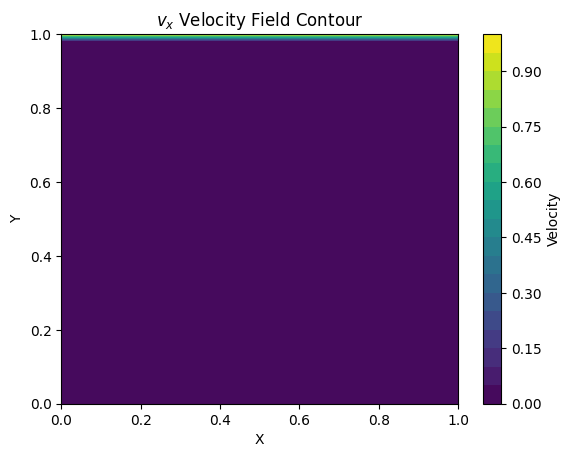

In [8]:
# Plot initial conditions
plt.figure()
CP = plt.contourf(X, Y, ic_U[:,:,0], levels=20, cmap='viridis')
plt.title('$v_x$ Velocity Field Contour')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(CP, label='Velocity')
plt.show()


### Samples of Boundary Conditions (BC)

In [9]:
# Left boundary conditions
left_bc_X   = X[[0], :]
left_bc_Y   = Y[[0], :]
left_bc_vx  = ic_U[[0], :, 0]
left_bc_vy  = ic_U[[0], :, 1]
left_bc_p   = ic_U[[0], :, 2]

# Right boundary conditions
right_bc_X  = X[[-1], :]
right_bc_Y  = Y[[-1], :]
right_bc_vx  = ic_U[[-1], :, 0]
right_bc_vy  = ic_U[[-1], :, 1]
right_bc_p   = ic_U[[-1], :, 2]

# Top boundary conditions
top_bc_X  = X[:, [-1]]
top_bc_Y  = Y[:, [-1]]
top_bc_vx  = ic_U[:, [-1], 0]
top_bc_vy  = ic_U[:, [-1], 1]
top_bc_p   = ic_U[:, [-1], 2]

# Bottom boundary conditions
bottom_bc_X   = X[:, [0]]
bottom_bc_Y   = Y[:, [0]]
bottom_bc_vx  = ic_U[:, [0], 0]
bottom_bc_vy  = ic_U[:, [0], 1]
bottom_bc_p   = ic_U[:, [0], 2]


### Number of training samples for BC

In [10]:
print(left_bc_X.shape)
print(right_bc_X.shape)
print(top_bc_X.shape)
print(bottom_bc_X.shape)

print(left_bc_vx.shape)
print(right_bc_vx.shape)
print(top_bc_vx.shape)
print(bottom_bc_vx.shape)

torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([50, 1])
torch.Size([50, 1])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([50, 1])
torch.Size([50, 1])


In [11]:
X_train_bc  = torch.concat([left_bc_X.flatten(), right_bc_X.flatten(), top_bc_X.flatten(), bottom_bc_X.flatten()]).view((-1,1)).to(device)
Y_train_bc  = torch.concat([left_bc_Y.flatten(), right_bc_Y.flatten(), top_bc_Y.flatten(), bottom_bc_Y.flatten()]).view((-1,1)).to(device)
vx_train_bc = torch.concat([left_bc_vx.flatten(), right_bc_vx.flatten(), top_bc_vx.flatten(), bottom_bc_vx.flatten()]).view((-1,1)).to(device)
vy_train_bc = torch.concat([left_bc_vy.flatten(), right_bc_vy.flatten(), top_bc_vy.flatten(), bottom_bc_vy.flatten()]).view((-1,1)).to(device)
p_train_bc  = torch.concat([left_bc_p.flatten(), right_bc_p.flatten(), top_bc_p.flatten(), bottom_bc_p.flatten()]).view((-1,1)).to(device)

print(X_train_bc.shape, Y_train_bc.shape, vx_train_bc.shape)

N_bc = X_train_bc.shape[0]

torch.Size([200, 1]) torch.Size([200, 1]) torch.Size([200, 1])


### Samples of Collocation Points (CP)

In [12]:
# Domain bounds
x_lb = X_test[0]
x_ub = X_test[-1]
y_lb = Y_test[0]
y_ub = Y_test[-1]
print(x_lb, x_ub, y_lb, y_ub)

# Choose (N_collocation) collocation Points to Evaluate the PDE
N_cp = 200
print(f'Number of collocation points for training: {N_cp}')

# Generate collocation points (CP)
X_train_cp = torch.FloatTensor(N_cp, 1).uniform_(float(x_lb), float(x_ub)).to(device)
Y_train_cp = torch.FloatTensor(N_cp, 1).uniform_(float(y_lb), float(y_ub)).to(device)

# Append collocation points and boundary points for training
X_train = torch.vstack((X_train_cp, X_train_bc)).float().to(device)
Y_train = torch.vstack((Y_train_cp, Y_train_bc)).float().to(device)
print(X_train.shape, Y_train.shape)

tensor([0.]) tensor([1.]) tensor([0.]) tensor([1.])
Number of collocation points for training: 200
torch.Size([400, 1]) torch.Size([400, 1])


### Plot collocation points

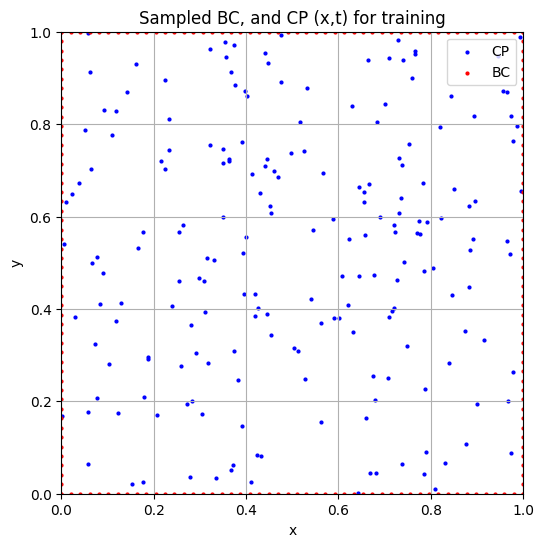

In [13]:
# Create a figure and axis object
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Scatter plot for CP points
ax.scatter(X_train_cp.detach().cpu().numpy(), Y_train_cp.detach().cpu().numpy(),
           s=4., c='blue', marker='o', label='CP')
# Scatter plot for BC points

ax.scatter(X_train_bc.detach().cpu().numpy(), Y_train_bc.detach().cpu().numpy(),
           s=4., c='red', marker='o', label='BC')

ax.set_title('Sampled BC, and CP (x,t) for training')
ax.set_xlim(x_lb, x_ub)
ax.set_ylim(y_lb, y_ub)
ax.grid(True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='upper right')
ax.set_aspect('equal', 'box')
plt.show()


### Create Neuromancer datasets

In [14]:
from neuromancer.dataset import DictDataset

# turn on gradients for PINN
X_train.requires_grad=True
Y_train.requires_grad=True

# Training dataset
train_data = DictDataset({'x': X_train.to(device), 'y':Y_train.to(device)}, name='train')
# test dataset
test_data = DictDataset({'x': X_test.to(device), 'y':Y_test.to(device)}, name='test')

# torch dataloaders
batch_size = X_train.shape[0]  # full batch training
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         collate_fn=test_data.collate_fn,
                                         shuffle=False)

## PINN Architecture in Neuromancer

### Neural Network Architecture

We will use a neural network to approximate the PDE solution:
$$\hat{\boldsymbol{v^*}} = NN_{\theta}(x^*,y^*)$$  

In [15]:
from neuromancer.modules import blocks
from neuromancer.system import Node, System

# neural net to solve the PDE problem
net = blocks.KANBlock(insize=2,outsize=3, num_layers=2, hidden_size=32)

# symbolic wrapper of the neural net
pde_net = Node(net, ['x', 'y'], ['U'], name='net')

In [16]:
print("symbolic inputs  of the pde_net:", pde_net.input_keys)
print("symbolic outputs of the pde_net:", pde_net.output_keys)

symbolic inputs  of the pde_net: ['x', 'y']
symbolic outputs of the pde_net: ['U']


In [17]:
pde_net(train_data.datadict)

{'U': tensor([[ 0.0404,  0.0404,  0.0520],
         [ 0.0861,  0.1114,  0.1495],
         [ 0.0319,  0.0275,  0.0434],
         ...,
         [-0.0006, -0.0102,  0.0273],
         [-0.0010, -0.0106,  0.0277],
         [-0.0014, -0.0109,  0.0281]], grad_fn=<AddBackward0>)}

In [18]:
# forward pass
net_out = pde_net(train_data.datadict)
print(pde_net(train_data.datadict).keys())
print(pde_net(train_data.datadict)['U'].shape)

dict_keys(['U'])
torch.Size([400, 3])


###  Define Physics-informed terms

Our neural network approximation  must satisfy the PDE equations  $NN_{\theta}(x,t) \approx y(x,t)$.
Thus we define the physics-informed layers as $f_{\texttt{PINN}}$:

$$f_{\texttt{PINN}}(t,x)=
\frac{\partial NN_{\theta}(x,t)}{\partial t}+ NN_{\theta}(x,t) \frac{\partial NN_{\theta}(x,t)}{\partial x} -\nu\frac{\partial^2 NN_{\theta}(x,t)}{\partial x^2}
 $$

We can obtain the derivatives of the neural net $\frac{\partial NN_{\theta}}{\partial t},\frac{\partial^2 NN_{\theta}}{\partial x^2}$ using [Automatic Diferentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).

To simplify the implementation of $f_{\texttt{PINN}}$ we exploit the symbolic variable of the Neuromancer library.

In [19]:
from neuromancer.constraint import variable

# symbolic Neuromancer variables
U = variable('U')
vx = variable('U')[:,[0]]
vy = variable('U')[:,[1]]
p = variable('U')[:,[2]]
x = variable('x')  # spatial coordinate 1
y = variable('y')  # spatial coordinate 2

In [20]:
# get the symbolic derivatives
dvx_dx   = vx.grad(x)
dvy_dx   = vy.grad(x)
dp_dx    = p.grad(x)

dvx_dy   = vx.grad(y)
dvy_dy   = vy.grad(y)
dp_dy    = p.grad(y)

d2vx_dx2 = dvx_dx.grad(x)
d2vy_dx2 = dvy_dx.grad(x)
d2vx_dy2 = dvx_dy.grad(y)
d2vy_dy2 = dvy_dy.grad(y)

# get the PINN form
f_pinn_1 = (1./Re)*(d2vx_dx2 + d2vx_dy2) - vx * dvx_dx - vy * dvx_dy - dp_dx
f_pinn_2 = (1./Re)* (d2vy_dx2 + d2vy_dy2) - vy * dvy_dx - vy * dvy_dy - dp_dy 
f_pinn_3 = dvx_dx + dvy_dy


In [21]:
train_data.datadict.keys()

dict_keys(['x', 'y'])

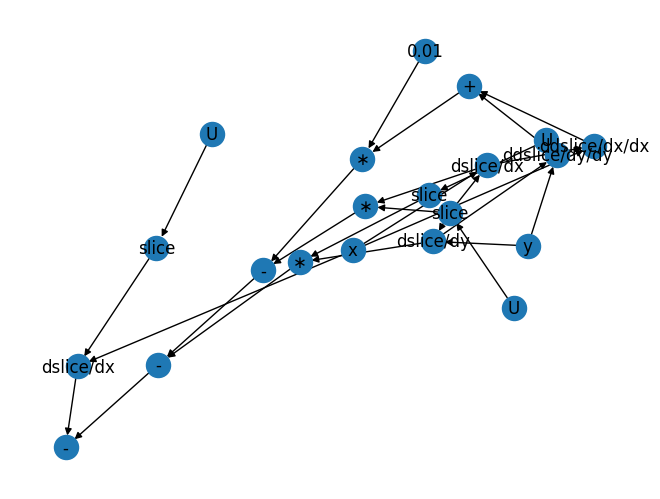

In [22]:
f_pinn_1.show()

In [23]:
# check the shapes of the forward pass of the symbolic PINN terms
print(f"vx: {vx({**net_out, **train_data.datadict}).shape}")
print(f"vy: {vy({**net_out, **train_data.datadict}).shape}")
print(f"p: {p({**net_out, **train_data.datadict}).shape}")

print(f"dvx_dx: {dvx_dx({**net_out, **train_data.datadict}).shape}")
print(f"dvy_dx: {dvy_dx({**net_out, **train_data.datadict}).shape}")
print(f"dp_dx: {dp_dx({**net_out, **train_data.datadict}).shape}")

print(f"dvx_dy: {dvx_dy({**net_out, **train_data.datadict}).shape}")
print(f"dvy_dy: {dvy_dy({**net_out, **train_data.datadict}).shape}")
print(f"dp_dy: {dp_dy({**net_out, **train_data.datadict}).shape}")

print(f"d2vx_dx2: {d2vx_dx2({**net_out, **train_data.datadict}).shape}")
print(f"d2vy_dx2: {d2vy_dx2({**net_out, **train_data.datadict}).shape}")
print(f"d2vx_dy2: {d2vx_dy2({**net_out, **train_data.datadict}).shape}")
print(f"d2vy_dy2: {d2vy_dy2({**net_out, **train_data.datadict}).shape}")

print(f"f_pinn_1: {f_pinn_1({**net_out, **train_data.datadict}).shape}")
print(f"f_pinn_2: {f_pinn_2({**net_out, **train_data.datadict}).shape}")
print(f"f_pinn_3: {f_pinn_3({**net_out, **train_data.datadict}).shape}")


vx: torch.Size([400, 1])
vy: torch.Size([400, 1])
p: torch.Size([400, 1])
dvx_dx: torch.Size([400, 1])
dvy_dx: torch.Size([400, 1])
dp_dx: torch.Size([400, 1])
dvx_dy: torch.Size([400, 1])
dvy_dy: torch.Size([400, 1])
dp_dy: torch.Size([400, 1])
d2vx_dx2: torch.Size([400, 1])
d2vy_dx2: torch.Size([400, 1])
d2vx_dy2: torch.Size([400, 1])
d2vy_dy2: torch.Size([400, 1])
f_pinn_1: torch.Size([400, 1])
f_pinn_2: torch.Size([400, 1])
f_pinn_3: torch.Size([400, 1])


### PINNs' Loss function terms

**PDE Collocation Points Loss:**  
We evaluate our PINN $f_{\texttt{PINN}}$ over given number ($N_{cp}$) of collocation points (CP) and minimize the PDE residuals in the following loss function:

$$\ell_{cp}=\frac{1}{N_f}\sum^{N_{cp}}_{i=1}|f_{\texttt{PINN}}(x_{cp}^i)|^2$$


If $f_{\texttt{PINN}}\rightarrow 0$ then our PINN will be respecting the physical law.

**PDE Initial and Boundary Conditions Loss:**

We select $N_{bc}$ points from our BC and used them in the following supervised learning loss function:

$$\ell_{bc}=\frac{1}{N_u}\sum^{N_{bc}}_{i=1}|v(x_{bc}^i)-NN_{\theta}(x_{bc}^i)|^2$$

#### Total Loss:
The total loss is just a weighted sum of PDE residuals over CP and supervised learning residuals over BC.
$$\ell_{\text{PINN}}= \omega_{cp} \ell_{cp}+ \omega_{bc} \ell_{bc}$$

with scaling weights $\omega_{cp}, \omega_{bc}$.

In [24]:
print(f"U: {U({**net_out, **train_data.datadict}).shape}")


U: torch.Size([400, 3])


In [25]:
# scaling factor for better convergence
scaling_cp = 10.
scaling_bc = 100.
scaling_continuity = 10.

# PDE CP loss (MSE)
l_cp_1 = scaling_cp*(f_pinn_1 == torch.tensor(0.).to(device))^2
l_cp_2 = scaling_cp*(f_pinn_2 == torch.tensor(0.).to(device))^2
l_cp_3 = scaling_continuity*(f_pinn_3 == torch.tensor(0.).to(device))^2
l_cp_1.update_name("loss_cp_1")
l_cp_2.update_name("loss_cp_2")
l_cp_3.update_name("loss_cp_3")

# PDE BC loss (MSE)
# note: remember that we concatenated CP and BC
l_bc_1 = scaling_bc*( vx[-N_bc:] == vx_train_bc)^2
l_bc_2 = scaling_bc*( vy[-N_bc:] == vy_train_bc)^2
l_bc_3 = scaling_bc*( p[-N_bc:] == p_train_bc)^2

l_bc_1.update_name("loss_bc_1")
l_bc_2.update_name("loss_bc_2")
l_bc_3.update_name("loss_bc_3")

# output constraints to bound the PINN solution
# con_1 = (U[0,2]==1.0)

##  Train the PINN to solve the PDE

We use stochastic gradient descent to optimize the parameters $\theta$ of the neural network $NN_{\theta}(t,x)$ approximating the solution to the PDE equation $y(t,x)$ using the PINN loss $\ell_{\text{PINN}}$ evaluated over sampled CP, IP, and BC.

### Define the optimization problem in Neuromancer

In [26]:
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem

pinn_loss = PenaltyLoss(objectives=[l_cp_1, l_cp_2, l_cp_3, l_bc_1, l_bc_2, l_bc_3], constraints=[])

# construct the PINN optimization problem
problem = Problem(nodes=[pde_net],      # list of nodes (neural nets) to be optimized
                  loss=pinn_loss,       # physics-informed loss function
                  grad_inference=True   # argument for allowing computation of gradients at the inference time)
                 )

### Construct Trainer and solve the problem  

In [27]:
from neuromancer.trainer import Trainer

optimizer = torch.optim.AdamW(problem.parameters(), lr=3e-3)
epochs = 3000

#  Neuromancer trainer
trainer = Trainer(
    problem.to(device),
    train_loader,
    optimizer=optimizer,
    epochs=epochs,
    epoch_verbose=200,
    train_metric='train_loss',
    dev_metric='train_loss',
    eval_metric="train_loss",
    warmup=epochs,
    device=device
)

In [28]:
# Train PINN
t0 = time()
best_model = trainer.train()
print(f"Elapsed time: {time()-t0} s")

# load best trained model
problem.load_state_dict(best_model)

/Users/pere066/Projects/neuromancer_kan_integration/.venv/lib/python3.10/site-packages/neuromancer/constraint.py:172: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)


epoch: 0  train_loss: 23.98160171508789
epoch: 200  train_loss: 1.1732841730117798
epoch: 400  train_loss: 0.9374942779541016
epoch: 600  train_loss: 0.8077342510223389
epoch: 800  train_loss: 0.7385823130607605
epoch: 1000  train_loss: 0.7018476724624634
epoch: 1200  train_loss: 0.664279043674469
epoch: 1400  train_loss: 0.6432887315750122
epoch: 1600  train_loss: 0.6288663148880005
epoch: 1800  train_loss: 0.615644633769989
epoch: 2000  train_loss: 0.6021663546562195
epoch: 2200  train_loss: 0.5958497524261475
epoch: 2400  train_loss: 0.5815654397010803
epoch: 2600  train_loss: 0.5723129510879517
epoch: 2800  train_loss: 0.5634610056877136
Elapsed time: 206.08669805526733 s


<All keys matched successfully>

### Plots

In [29]:
# Evaluate trained PINN on test data (all the data in the domain)
PINN = problem.nodes[0]
U_pinn = PINN(test_data.datadict)['U']

# arrange data for plotting
vx_pinn = U_pinn[:,0].reshape(shape=[Nx,Ny]).detach().cpu()
vy_pinn = U_pinn[:,1].reshape(shape=[Nx,Ny]).detach().cpu()
p_pinn = U_pinn[:,2].reshape(shape=[Nx,Ny]).detach().cpu()


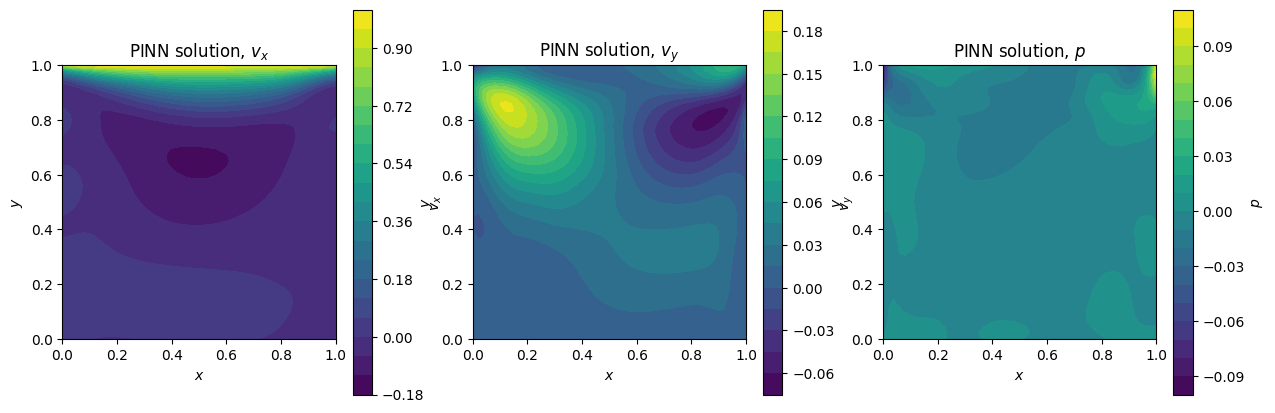

In [30]:
# plot PINN solution
plt.figure(figsize=(15, 5))  # Increase figure size for better visibility
# cbarticks = np.arange(-.1,1.1,0.05)

# # Plot for the second heatmap (PINN solution)
ax2 = plt.subplot(1, 3, 1)
CP2 = plt.contourf(X, Y, vx_pinn, levels=20, cmap='viridis')
plt.title('PINN solution, $v_x$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar(CP2, label='$v_x$')
ax2.set_aspect('equal', adjustable='box')

ax2 = plt.subplot(1, 3, 2)
CP2 = plt.contourf(X, Y, vy_pinn, levels=20, cmap='viridis')
plt.title('PINN solution, $v_y$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar(CP2, label='$v_y$')
ax2.set_aspect('equal', adjustable='box')

ax2 = plt.subplot(1, 3, 3)
CP2 = plt.contourf(X, Y, p_pinn, levels=20, cmap='viridis')
plt.title('PINN solution, $p$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar(CP2, label='$p$')
ax2.set_aspect('equal', adjustable='box')


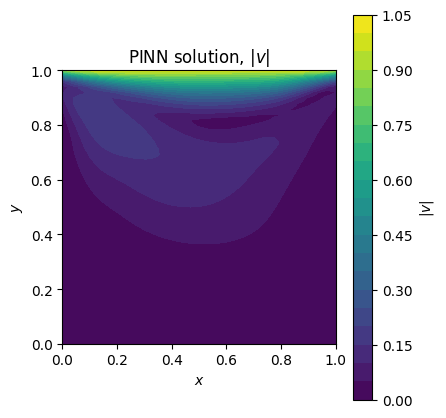

In [31]:
# plot PINN solution
plt.figure(figsize=(15, 5))  # Increase figure size for better visibility
# cbarticks = np.arange(-0.1,1.1,0.05)

# # Plot for the second heatmap (PINN solution)
ax2 = plt.subplot(1, 3, 1)
CP2 = plt.contourf(X, Y, torch.sqrt(vx_pinn**2 + vy_pinn**2), levels=20, cmap='viridis')
plt.title('PINN solution, $|v|$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar(CP2, label='$|v|$')
ax2.set_aspect('equal', adjustable='box')


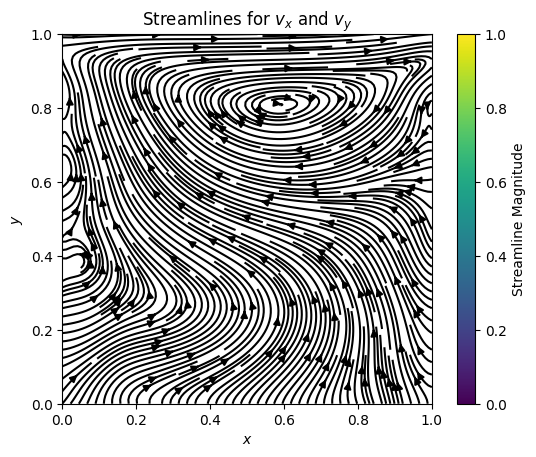

In [32]:
x_ = np.linspace(0, 1, Nx)
y_ = np.linspace(0, 1, Ny)

ax = plt.subplot(1, 1, 1)
strm = plt.streamplot(x_, y_, vx_pinn.T, vy_pinn.T, color='k', density=3, minlength=0.1)
plt.title('Streamlines for $v_x$ and $v_y$')
plt.xlabel('$x$')
plt.ylabel('$y$')
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(0., 1.)
ax.set_ylim(0., 1.)
plt.colorbar(strm.lines, label='Streamline Magnitude')
plt.show()
